In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import cv2
from util_functions import *
from global_vars import *##

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
# load rgbs, depths and hand joint actions
FRAME_STEP = 2 # the step I used to extract waypoints, i.e., in a video recorded at 100fps, I extracted waypoints every 30 frames (otherwise it takes too long)
path = '../assets/demos/kettle/kettle_on_stove_0/'
rgbs = np.load(f'{path}rgbs_subsampled_{FRAME_STEP}.npy')
depths = np.load(f'{path}depths_subsampled_{FRAME_STEP}.npy')
print('rgbs.shape:', rgbs.shape)
# vizualize the recorded demo in slower motion
# for i in range(0, rgbs.shape[0]):
#     im = cv2.cvtColor(rgbs[i], cv2.COLOR_BGR2RGB)
#     # im = cv2.cvtColor(hands_depth[i],cv2.COLOR_GRAY2BGR)
#     cv2.imshow("rgb", im)
#     cv2.waitKey(1)
#     time.sleep(0.001)
# cv2.destroyAllWindows()


rgbs.shape: (22, 480, 640, 3)


In [3]:

MANO_HAND_IDS = {"wrist": 0,        "index_mcp": 1,     "index_pip": 2, 
                 "index_dip": 3,    "middle_mcp": 4,    "middle_pip": 5, 
                 "middle_dip": 6,   "pinkie_mcp": 7,    "pinkie_pip": 8, 
                 "pinkie_dip": 9,   "ring_mcp": 10,     "ring_pip": 11, 
                 "ring_dip": 12,    "thumb_mcp": 13,    "thumb_pip": 14, 
                 "thumb_dip": 15,   "thumb_tip": 16,    "index_tip": 17, 
                 "middle_tip": 18,  "ring_tip": 19,     "pinky_tip": 20}
# if you want to understand what the dip, pip etc... corresponds to check this: https://images.app.goo.gl/RepR8HWBXTQTQoFx8

"""
the below is what you likely need. you can vizualize them at the following cell."""
actions = np.load(f'{path}/hand_joints_kpts_3d.npy')
rgbs = rgbs[:len(actions)] # sometimes some actions are missing because they were not extracted during processing as for some frames there were no hand present and so they are automatically discarded
depths = depths[:len(actions)]
print(actions)

[[[-0.304621   -0.10859927  0.50407235]
  [-0.27106214 -0.14405854  0.57779035]
  [-0.26834638 -0.15170979  0.6068985 ]
  ...
  [-0.29553912 -0.1111746   0.64711703]
  [-0.31408319 -0.10136141  0.63363227]
  [-0.32914145 -0.10798385  0.61480448]]

 [[-0.30368825 -0.10471422  0.49352376]
  [-0.26667632 -0.13999396  0.56559324]
  [-0.26305328 -0.14819371  0.5944521 ]
  ...
  [-0.29171278 -0.1084166   0.63488979]
  [-0.31066279 -0.09832096  0.61929824]
  [-0.32601585 -0.10884729  0.60329731]]

 [[-0.30495274 -0.10208606  0.48978217]
  [-0.26702771 -0.13756471  0.56156089]
  [-0.26239293 -0.14566305  0.59029959]
  ...
  [-0.28821081 -0.10543939  0.63276227]
  [-0.30717727 -0.09119875  0.61556864]
  [-0.32217579 -0.09810997  0.5988465 ]]

 ...

 [[-0.02620215 -0.18584638  0.47066222]
  [ 0.0512469  -0.22321504  0.49008231]
  [ 0.06923394 -0.23312453  0.50922316]
  ...
  [ 0.06144787 -0.22466169  0.5670664 ]
  [ 0.04811718 -0.22212287  0.56885452]
  [ 0.02677075 -0.22576926  0.55981924]]

 [

In [4]:
# if you want to vizualize the hand joints, the point clouds and the scene for a frame
revert_cols = True
idx = 8 # pick the index
frame = idx * FRAME_STEP
depth_pcd = o3d.io.read_point_cloud(f"{path}/scene_files/live_image_pcd_{frame}.ply")
hand_mesh_pcd = o3d.io.read_triangle_mesh(f"{path}/scene_files/hand_mesh_{frame}.ply")
gripper_pcd = o3d.io.read_point_cloud(f"{path}/scene_files/gripper_pcd_{frame}.ply")
action = actions[idx]
depth_pcds = []
hand_mesh_pcds = []
gripper_pcds = []

depth_pcds_right_hand = []
hand_mesh_pcds_right_hand = []
gripper_pcds_right_hand = []

for i in range(0, rgbs.shape[0]):
    if os.path.exists(f"{path}/scene_files/live_image_pcd_{i * FRAME_STEP}.ply"):
        d = o3d.io.read_point_cloud(f"{path}/scene_files/live_image_pcd_{i * FRAME_STEP}.ply")
        if revert_cols:
            dcol = d.colors
            dcol = np.asarray(dcol)[:, ::-1] # reverse the order of the colors
            d.colors = o3d.utility.Vector3dVector(dcol)
        # print(dcol.shape)
        depth_pcds.append(d)
        hand_mesh_pcds.append(o3d.io.read_triangle_mesh(f"{path}/scene_files/hand_mesh_{i * FRAME_STEP}.ply"))
        gripper_pcds.append(o3d.io.read_point_cloud(f"{path}/scene_files/gripper_pcd_{i * FRAME_STEP}.ply"))

        depth_pcds_right_hand.append(o3d.io.read_point_cloud(f"{path}/scene_files/live_image_pcd_{i * FRAME_STEP}_right_hand.ply"))
        hand_mesh_pcds_right_hand.append(o3d.io.read_triangle_mesh(f"{path}/scene_files/hand_mesh_{i * FRAME_STEP}_right_hand.ply"))
        gripper_pcds_right_hand.append(o3d.io.read_point_cloud(f"{path}/scene_files/gripper_pcd_{i * FRAME_STEP}_right_hand.ply"))
    else:
        print(f"File {path}/scene_files/live_image_pcd_{i * FRAME_STEP}.ply does not exist")
sphere_viz_actions = []
for a in actions[idx]:
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.005)
    sphere.compute_vertex_normals()
    sphere.paint_uniform_color([0, 0, 1])
    sphere.translate(a)
    sphere_viz_actions.append(sphere)

# o3d.visualization.draw_geometries([depth_pcd, hand_mesh_pcd] + sphere_viz_actions) # the hand mesh is the detected one from MANO
# o3d.visualization.draw_geometries([depth_pcd] + sphere_viz_actions) # plot this if you want the points to be more visible
# o3d.visualization.draw_geometries([depth_pcd, hand_mesh_pcd, gripper_pcd] + sphere_viz_actions) # if you want to see the gripper we obtained, although maybe not very useful for you at this moment, better to predict hand keypoints


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_0_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_0_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_0_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_2_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_2_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_2_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_4_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_4_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_4_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_6_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_6_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_6_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_8_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_8_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_8_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_10_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_10_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_10_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_12_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_12_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_12_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_14_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_14_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_14_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_16_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_16_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_16_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_18_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_18_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_18_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_20_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_20_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_20_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_22_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_22_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_22_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_24_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_24_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_24_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_26_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_26_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_26_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_28_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_28_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_28_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_30_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_30_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_30_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_32_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_32_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_32_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_34_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_34_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_34_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_36_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_36_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_36_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_38_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_38_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_38_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_40_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_40_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_40_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/live_image_pcd_42_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/hand_mesh_42_right_hand.ply
[Open3D WARNING] Read PLY failed: unable to open file: ../assets/demos/kettle/kettle_on_stove_0//scene_files/gripper_pcd_42_right_hand.ply


RPly: Unable to open file
RPly: Unable to open file
RPly: Unable to open file


In [5]:
num = 3
o3d.visualization.draw_geometries([depth_pcds[num]] +  gripper_pcds + hand_mesh_pcds) # if you want to see the gripper we obtained, although maybe not very useful for you at this moment, better to predict hand keypoints

for num in range(0, len(depth_pcds)):

    o3d.visualization.draw_geometries([depth_pcds[num],gripper_pcds[num], hand_mesh_pcds[num]]) # if you want to see the gripper we obtained, although maybe not very useful for you at this moment, better to predict hand keypoints



KeyboardInterrupt: 

In [7]:
"""From the MANO_HAND_IDS you can extract which hand keypoints you
want from each action in the actions array, e.g., to get the index tip
for action for frame 5 index_tip_frame_5 = actions[5][MANO_HAND_IDS["index_tip"]].
For the two finger gripper case, I would reccomend using only MANO_HAND_IDS["index_tip"], 
MANO_HAND_IDS["middle_tip"], MANO_HAND_IDS["thumb_tip"], MANO_HAND_IDS['thumb_dip'] which are the two kpts 
at the index and thumb for a start.
"""

'From the MANO_HAND_IDS you can extract which hand keypoints you\nwant from each action in the actions array, e.g., to get the index tip\nfor action for frame 5 index_tip_frame_5 = actions[5][MANO_HAND_IDS["index_tip"]].\nFor the two finger gripper case, I would reccomend using only MANO_HAND_IDS["index_tip"], \nMANO_HAND_IDS["middle_tip"], MANO_HAND_IDS["thumb_tip"], MANO_HAND_IDS[\'thumb_dip\'] which are the two kpts \nat the index and thumb for a start.\n'

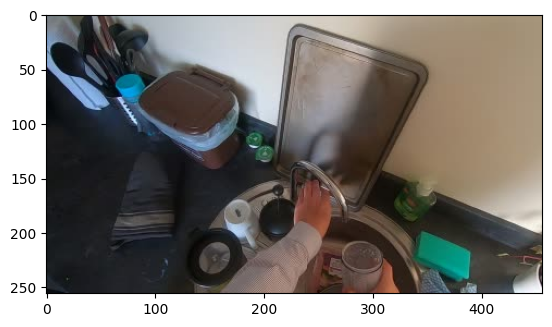

final text_encoder_type: bert-base-uncased
Model loaded from /home/george/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


2024-10-29 15:18:46.624741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 15:18:46.686000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 15:18:46.703364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 15:18:46.819191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 15:18:47.829587: W tensorflow/compiler/tf2

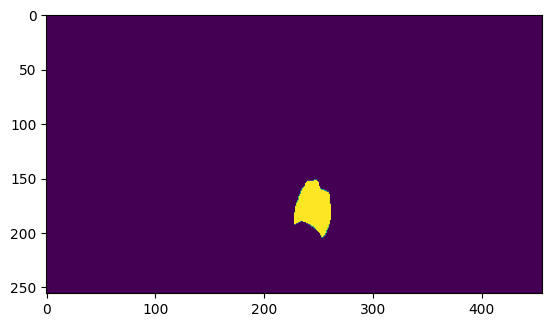

In [3]:
from lang_sam import LangSAM
from PIL import Image
import torch

model = LangSAM()



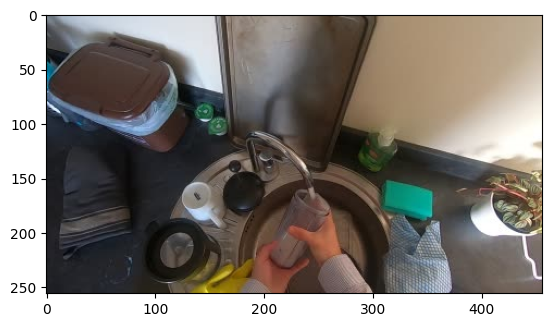

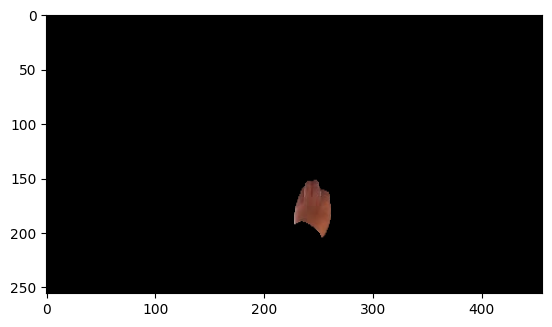

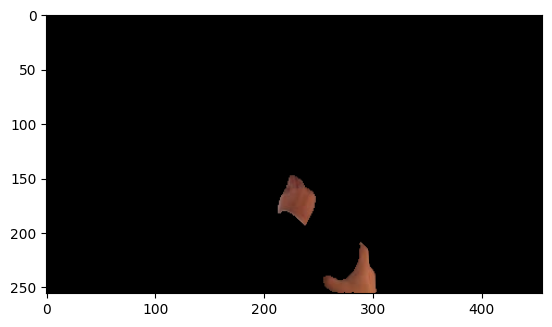

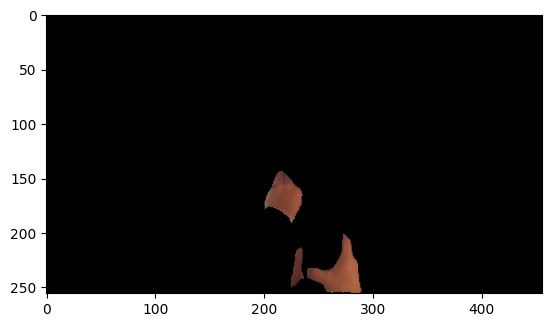

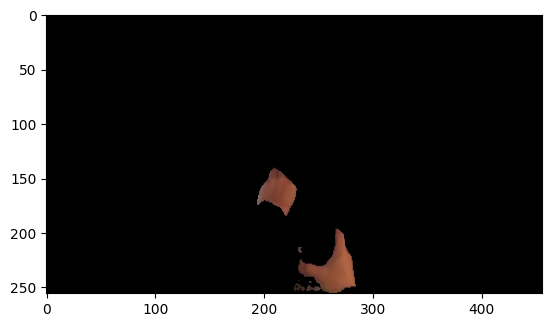

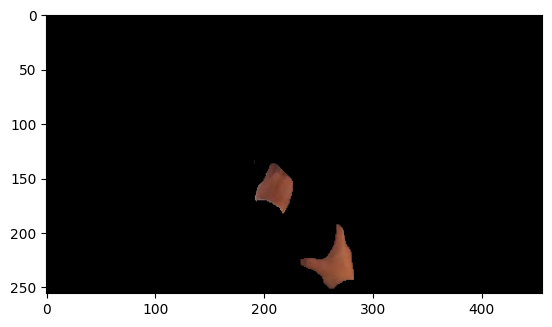

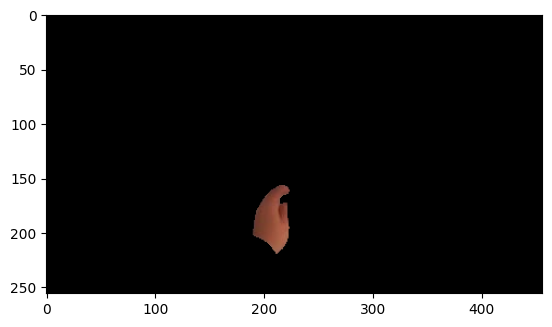

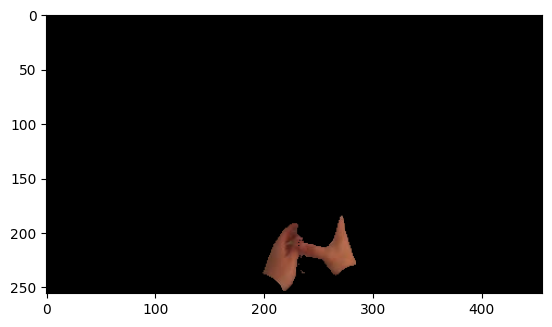

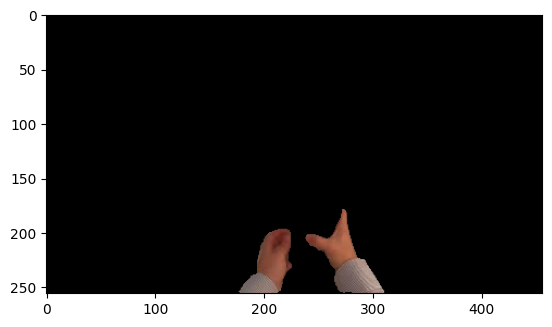

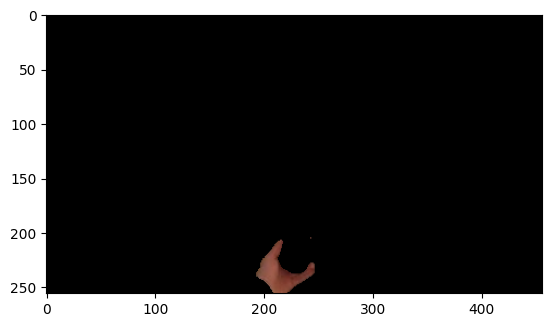

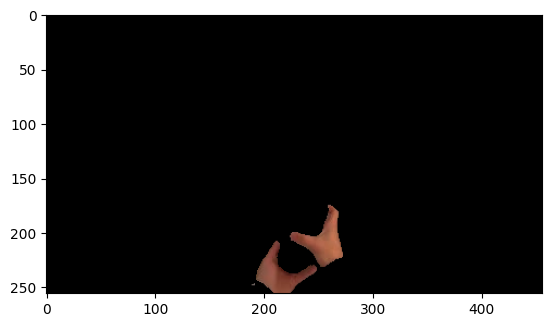

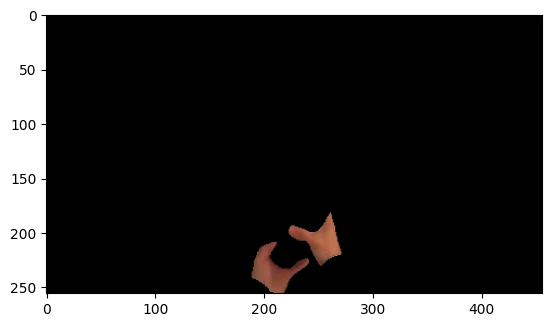

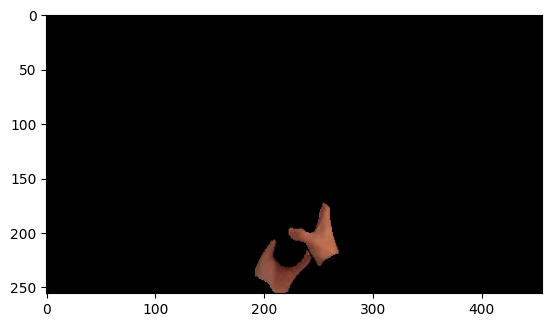

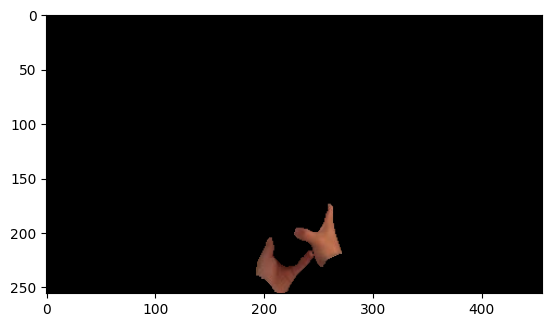

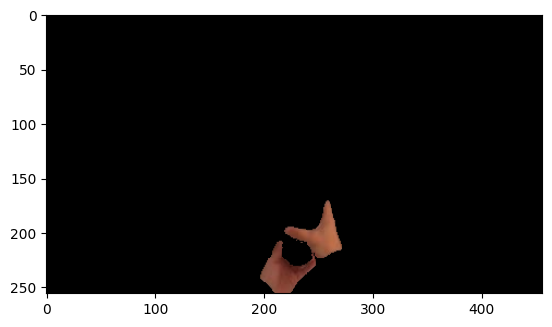

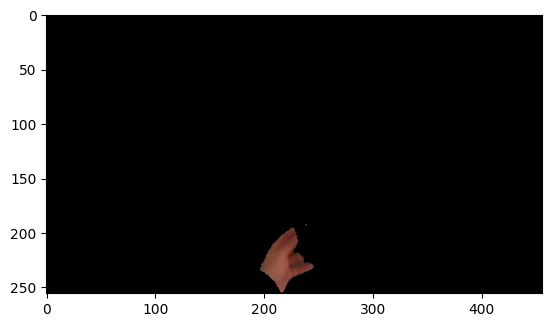

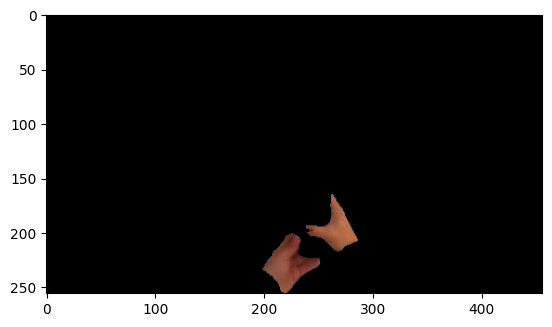

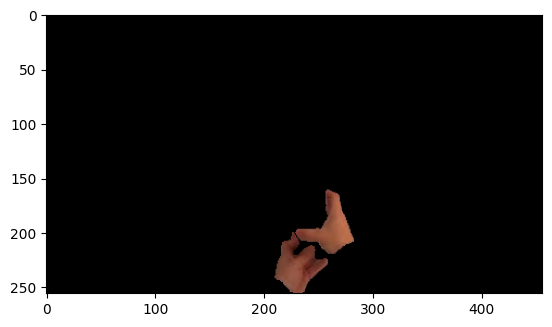

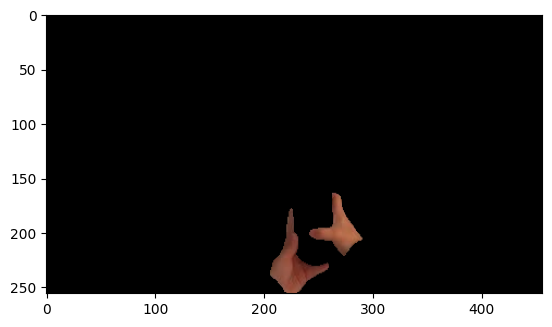

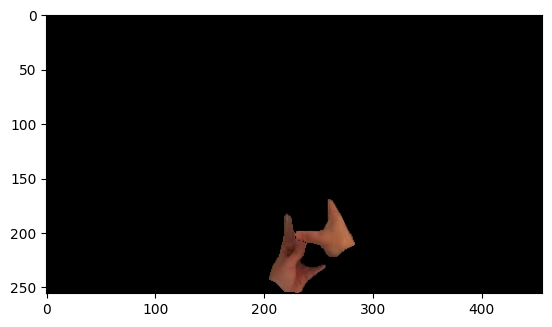

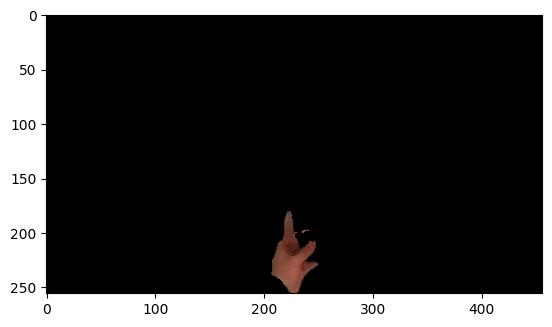

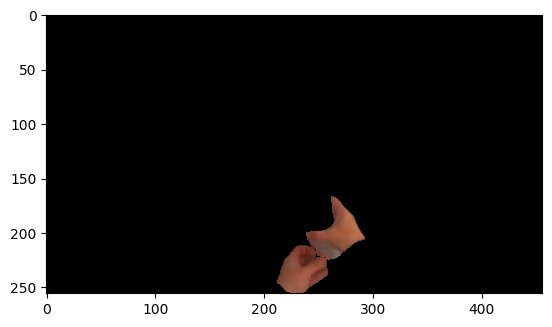

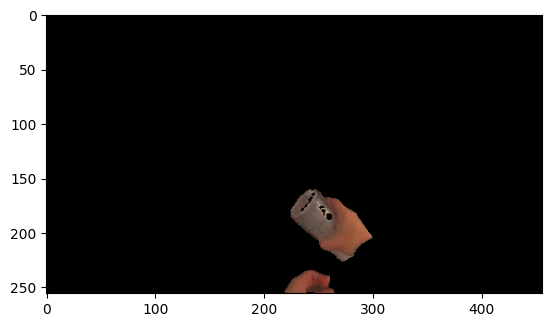

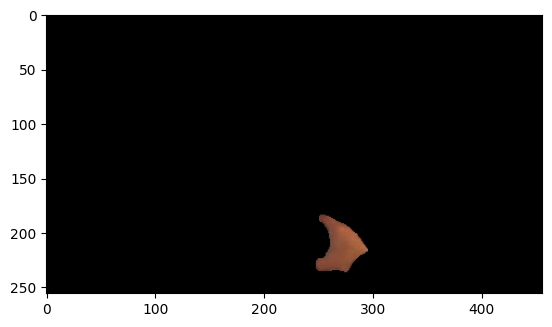

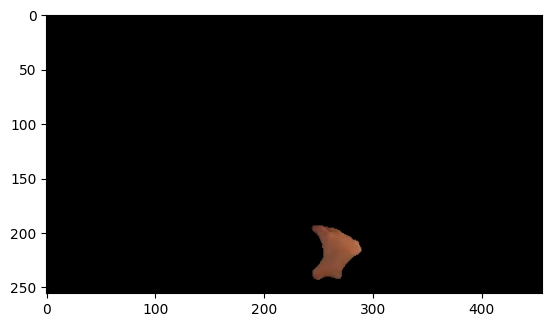

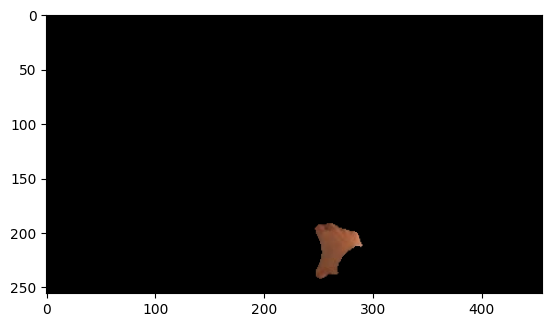

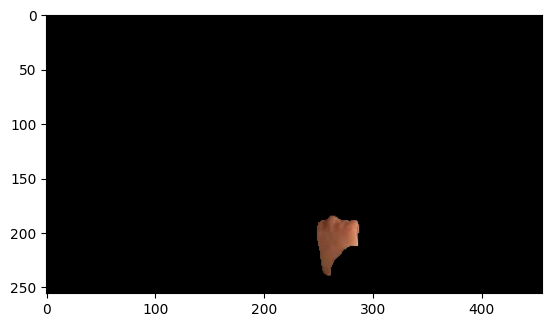

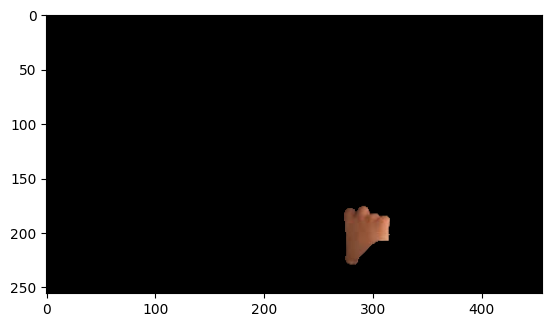

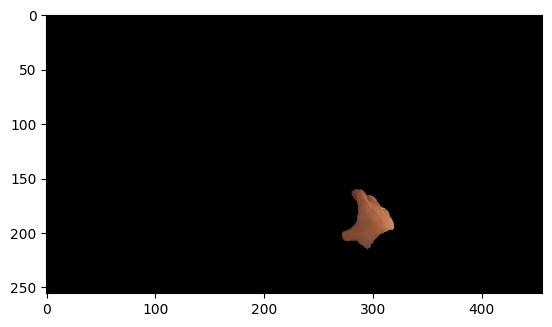

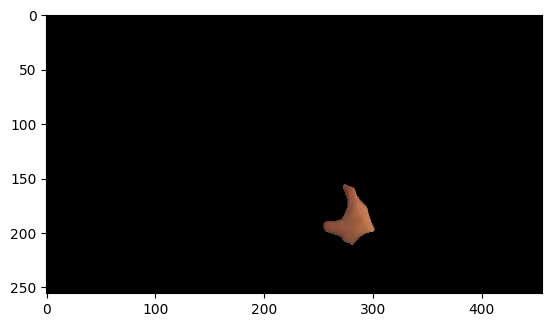

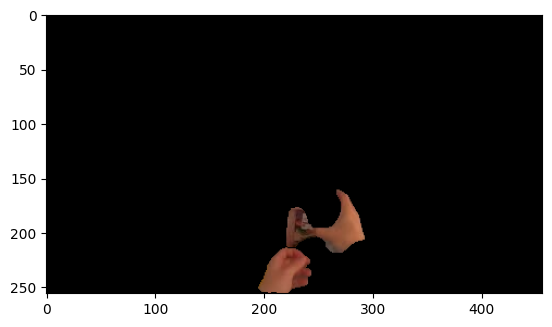

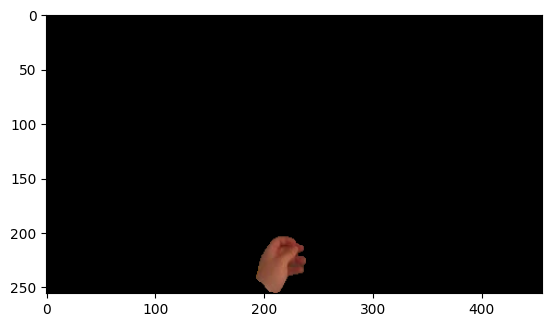

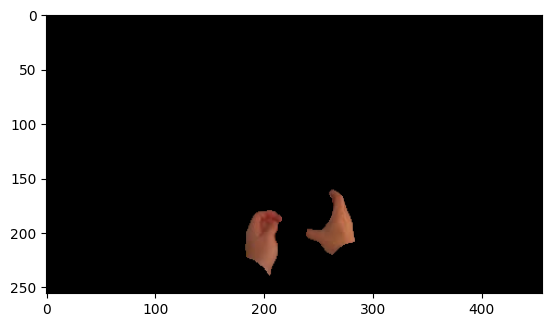

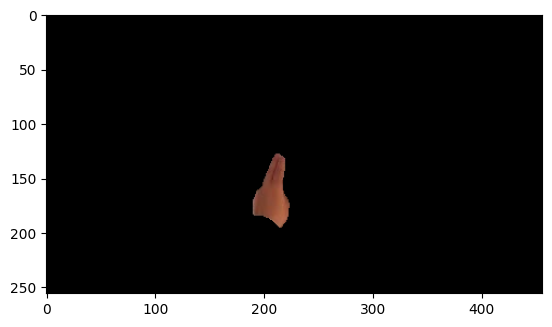

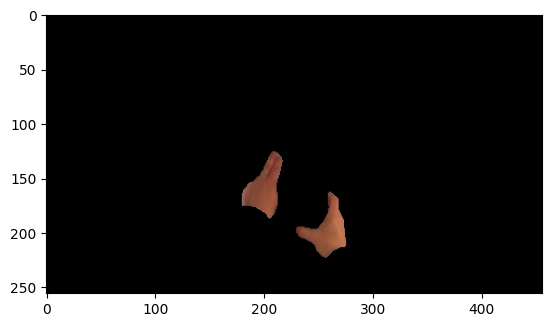

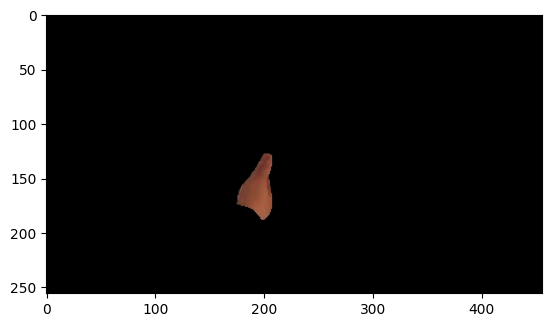

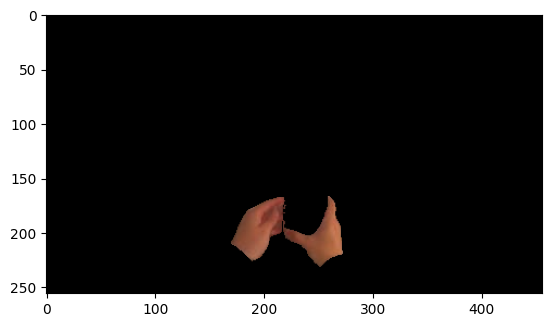

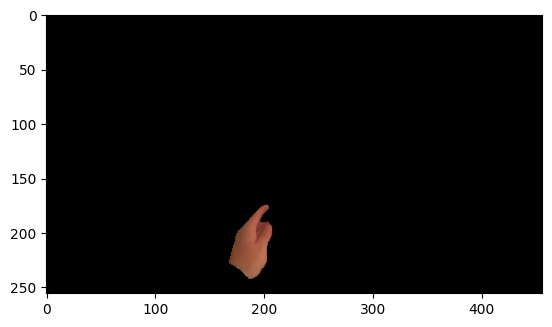

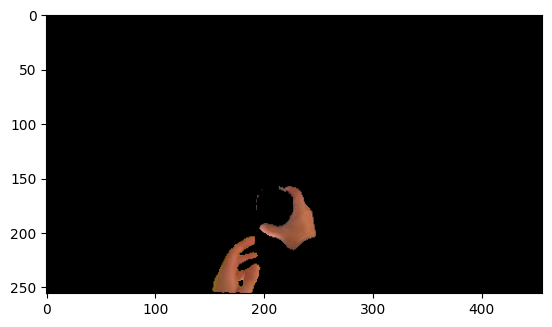

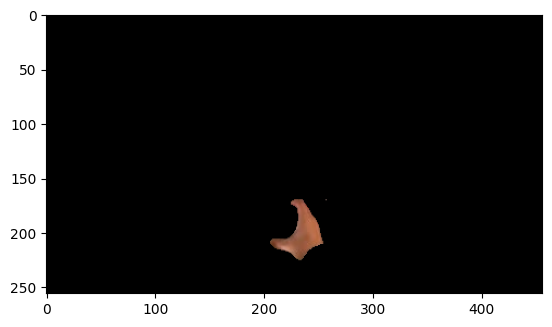

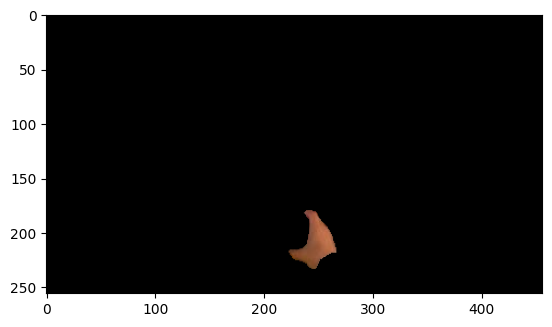

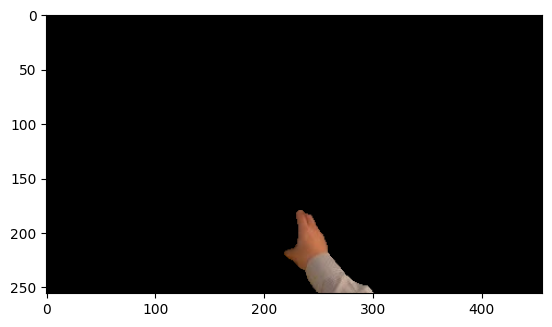

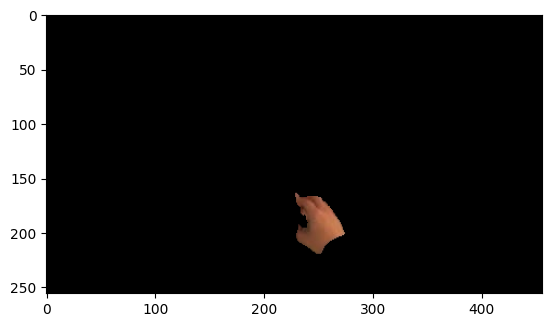

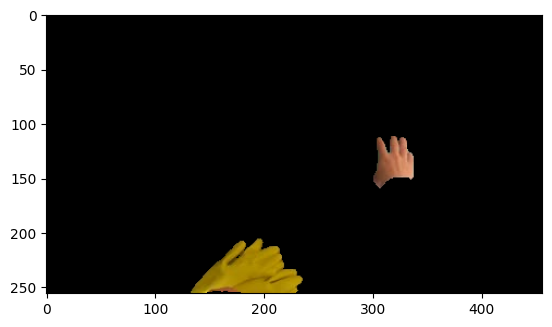

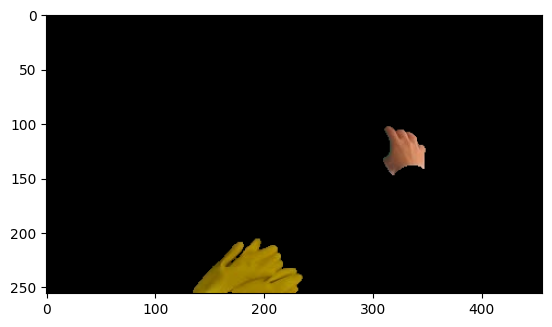

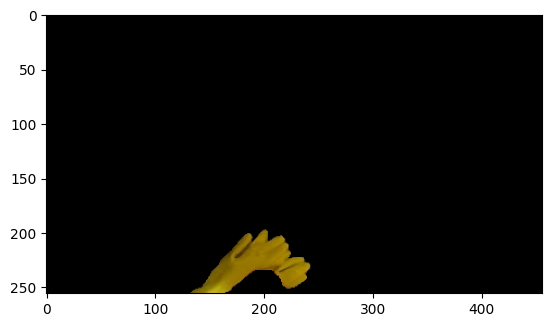

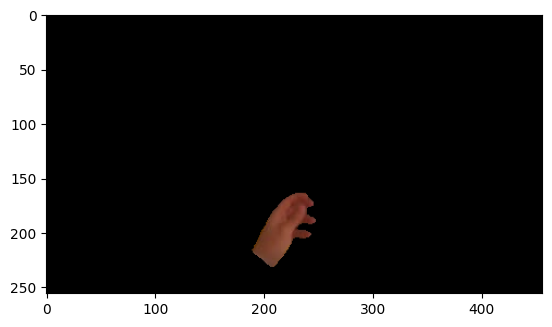

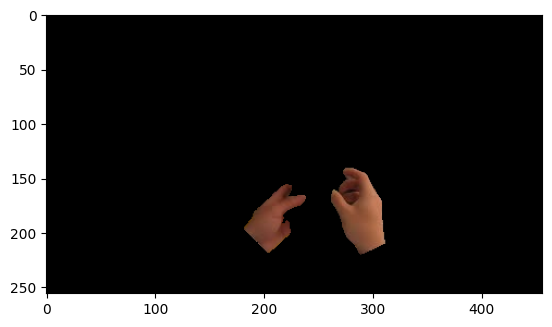

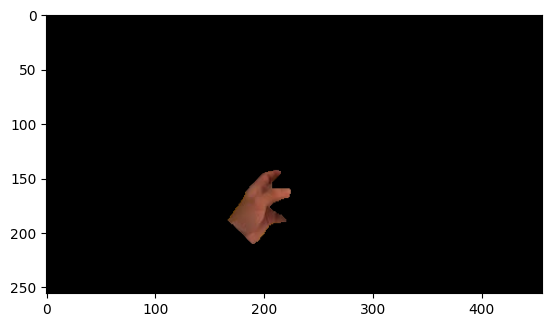

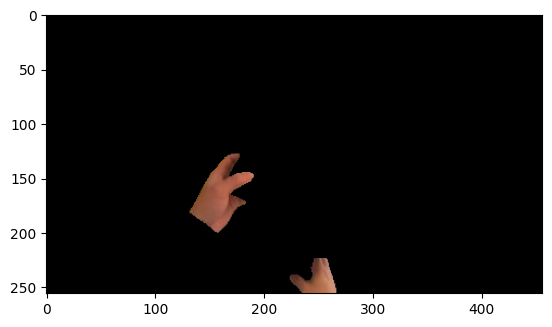

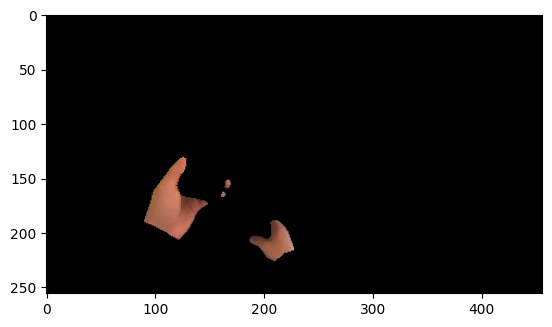

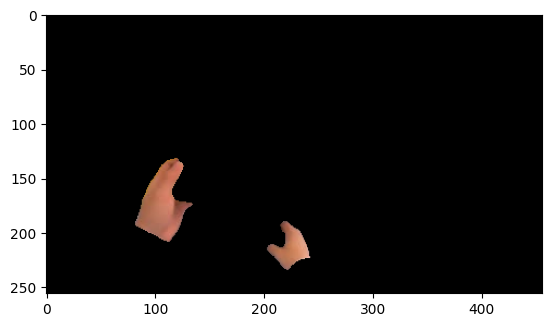

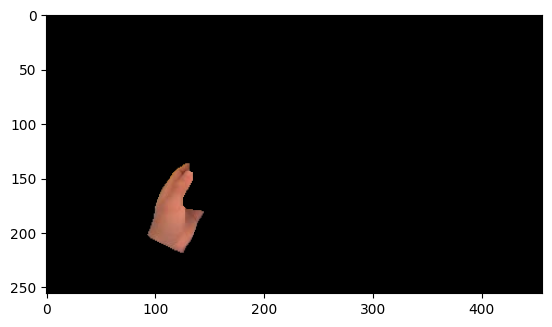

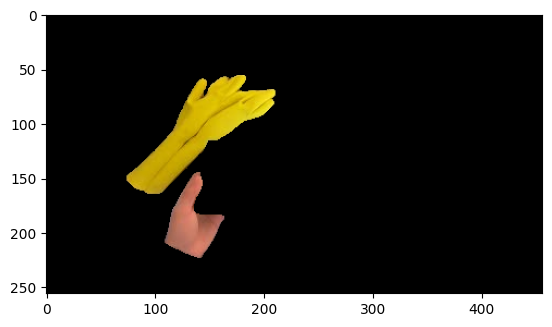

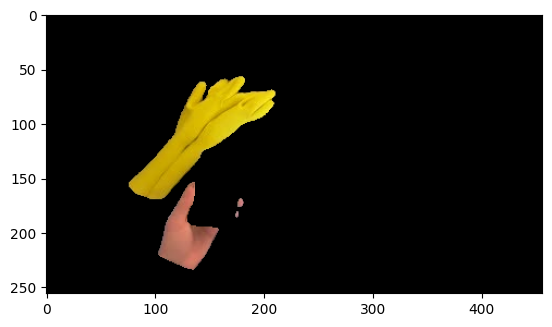

In [26]:
img = (rgbs[10] * 255).astype(np.uint8)
plt.imshow(img)
plt.show(
)
import copy

for r in rgbs:
    img = (r * 255).astype(np.uint8)    
    text_prompt = "one white human hand"
    image_pil = Image.fromarray(img)
    masks1, boxes, phrases, logits = model.predict(image_pil, text_prompt)
    # convert boolean mask to int
    imgs2 = copy.deepcopy(img)
    if len(masks1) > 0:
        inverted_mask = 1 - masks1[0].int()
        img2 = img * inverted_mask.unsqueeze(-1).repeat(1,1,3).numpy()
    img2 = (img2 * 255).astype(np.uint8)
    image_pil = Image.fromarray(img2)
    masks2, boxes, phrases, logits = model.predict(image_pil, text_prompt)

    final_mask = torch.ones_like(torch.tensor(img))
    if len(masks1) == 0:
        final_mask = masks2[0].int()
    elif len(masks2) == 0:
        final_mask = masks1[0].int()
    else:
        final_mask = masks1[0].int() + masks2[0].int()
    final_mask = torch.clamp(final_mask, 0, 1)
    plt.imshow(final_mask.unsqueeze(-1).repeat(1,1,3) * img)
    plt.show()
    # plt.imshow(masks1[0].unsqueeze(-1).repeat(1,1,3) * img)
    # plt.show()